## Import all modules

In [1]:
import pandas as pd # to start reading csv
import numpy as np
import matplotlib.pyplot as plt #plotting basic
import seaborn as sns
%matplotlib inline

## Reading all the files

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


## Opening the Training data

In [4]:
train_orders=orders[orders['eval_set']=='train']
trains=pd.merge(order_products_train, train_orders,how='left', on='order_id')
trains.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [5]:
prior_orders=orders[orders['eval_set']=='prior']
priors = pd.merge(order_products_prior, prior_orders, on='order_id',how ='right')
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


## Feature Engineering Part I: Product Features

- purchase_count: How many people purchased this product
- reordered_count: How many people reordered this product

In [6]:
priors_product = pd.merge(priors, products, on='product_id')
priors_product.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16


In [7]:
priors_product_purchase= priors_product.groupby(["product_id"]).size().reset_index(name ='purchase_count')
priors_product_purchase.head()

,product_id,purchase_count
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [8]:
priors_reordered = priors_product[priors_product['reordered'] == 1]
priors_reordered.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16
5,537,33120,2,1,180135,prior,15,2,8,3.0,Organic Egg Whites,86,16
6,582,33120,7,1,193223,prior,6,2,19,10.0,Organic Egg Whites,86,16


In [9]:
priors_product_reordered= priors_reordered.groupby(["product_id"]).size().reset_index(name ='reordered_count')
priors_product_reordered.head()

,product_id,reordered_count
0,1,1136
1,2,12
2,3,203
3,4,147
4,5,9


In [10]:
prods=pd.merge(priors_product_purchase,priors_product_reordered)
prods['prod_reorder_rate']=prods['reordered_count']/prods['purchase_count']
prods.head()

,product_id,purchase_count,reordered_count,prod_reorder_rate
0,1,1852,1136,0.613391
1,2,90,12,0.133333
2,3,277,203,0.732852
3,4,329,147,0.446809
4,5,15,9,0.600000


## Feature Engineering Part 2: User Features

- average number of days the user comes back from shopping
- average size of user cart
- total order per user

In [11]:
avg_reorder_days = prior_orders.groupby(["user_id"])['days_since_prior_order'].aggregate('count').reset_index(name='avg_days_prior_order')
avg_reorder_days.head()

,user_id,avg_days_prior_order
0,1,9
1,2,13
2,3,11
3,4,4
4,5,3


In [12]:
avg_usercart_size = priors_reordered.groupby(["user_id"])['add_to_cart_order'].aggregate('count').reset_index(name='avg_user_cart_size')
avg_usercart_size.head()

,user_id,avg_user_cart_size
0,1,41
1,2,93
2,3,55
3,4,1
4,5,14


In [13]:
total_order_per_user = prior_orders.groupby('user_id').size().reset_index(name='total_order_per_user')
total_order_per_user.head()

,user_id,total_order_per_user
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [14]:
users= pd.merge(avg_reorder_days,avg_usercart_size)
users_fin=pd.merge(users,total_order_per_user)
users_fin.head()

,user_id,avg_days_prior_order,avg_user_cart_size,total_order_per_user
0,1,9,41,10
1,2,13,93,14
2,3,11,55,12
3,4,4,1,5
4,5,3,14,4


# Feature Engineering Part 3: Product User features

- how many times this specific user buy this product
- reorder rate of this product by the user: reorder rate = product reordered by this customer/number of order by this customer

In [15]:
priors_product_purchase_spec= priors_product.groupby(["user_id","product_id"]).size().reset_index(name ='purchase_count_spec')
priors_product_purchase_spec.head()

,user_id,product_id,purchase_count_spec
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [16]:
priors_product_reordered_spec= priors_reordered.groupby(["user_id","product_id"]).size().reset_index(name ='reordered_count_spec')
priors_product_reordered_spec.head()

,user_id,product_id,reordered_count_spec
0,1,196,9
1,1,10258,8
2,1,12427,9
3,1,13032,2
4,1,13176,1


In [17]:
prods_user =pd.merge(priors_product_purchase_spec,priors_product_reordered_spec)
prods_user['reorder_ratio']=prods_user['reordered_count_spec']/prods_user['purchase_count_spec']
prods_user.head()

,user_id,product_id,purchase_count_spec,reordered_count_spec,reorder_ratio
0,1,196,10,9,0.900000
1,1,10258,9,8,0.888889
2,1,12427,10,9,0.900000
3,1,13032,3,2,0.666667
4,1,13176,2,1,0.500000


# Merging All prior data to train data
- merging train data with F.E 1, product id
- merging the product of the merged data with F.E 2, user id
- merging the product of the merged data with F.E 3, product id, user id

- Note that we should have 8-12 features up until here

In [45]:
trains_fe= pd.merge(trains, prods, on='product_id')
trains_fe.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,purchase_count,reordered_count,prod_reorder_rate
0,1,49302,1,1,112108,train,4,4,10,9.0,163,101,0.619632
1,816049,49302,7,1,47901,train,14,4,6,16.0,163,101,0.619632
2,1242203,49302,1,1,2993,train,15,0,7,7.0,163,101,0.619632
3,1383349,49302,11,1,41425,train,4,3,8,14.0,163,101,0.619632
4,1787378,49302,8,0,187205,train,5,4,14,30.0,163,101,0.619632


In [19]:
trains_fe1=pd.merge(trains_fe,users_fin)
trains_fe1.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
0,1,49302,1,1,112108,train,4,4,10,9.0,163,101,0.619632,2,9,3
1,1,11109,2,1,112108,train,4,4,10,9.0,4472,3192,0.713775,2,9,3
2,1,10246,3,0,112108,train,4,4,10,9.0,23826,12498,0.524553,2,9,3
3,1,49683,4,0,112108,train,4,4,10,9.0,97315,67313,0.691702,2,9,3
4,1,43633,5,1,112108,train,4,4,10,9.0,653,312,0.477795,2,9,3


In [51]:
trains_fe2=pd.merge(trains_fe1,prods_user, on=['user_id','product_id'])
trains_fe2.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user,purchase_count_spec,reordered_count_spec,reorder_ratio
0,1,49302,1,1,112108,train,4,4,10,9.0,163,101,0.619632,2,9,3,2,1,0.5
1,1,11109,2,1,112108,train,4,4,10,9.0,4472,3192,0.713775,2,9,3,2,1,0.5
2,1,43633,5,1,112108,train,4,4,10,9.0,653,312,0.477795,2,9,3,2,1,0.5
3,1,22035,8,1,112108,train,4,4,10,9.0,59676,45639,0.764780,2,9,3,2,1,0.5
4,816049,49302,7,1,47901,train,14,4,6,16.0,163,101,0.619632,12,22,13,2,1,0.5


In [21]:
#trains_product_purchase= trains_product.groupby(["product_id"]).size().reset_index(name ='purchase_count')
#trains_reordered = trains_product[trains_product['reordered'] == 1]
#trains_product_reordered= trains_reordered.groupby(["product_id"]).size().reset_index(name ='reordered_count')
#trains_product_merged1 = pd.merge(trains_product, trains_product_purchase, on='product_id')
#trains_product_merged2 = pd.merge(trains_product_merged1, trains_product_reordered, on='product_id')
#priors_product_comp= pd.priors_product_spec2 ({'order_id':order_list, 'product_id':product_list, dtype=np.int32})
#Use mapping to stop kernel from crashing?
#labels = np.array(labels,dtype = np.int8)
#df['user_id']= df.order_id.map(orders.user_id)
#df['product_count']=df.product_id.map(pc.product_id)

# Training and Testing Section

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
model = LogisticRegression()

/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Deciding the Predictor and Target Variables

In [52]:
#features
trains_fe2_x= trains_fe1.drop(['days_since_prior_order',
                               'order_id','product_id','user_id','add_to_cart_order','reordered','eval_set'], axis=1)
trains_fe2_x.head() #12 features as the predictor variables

,order_number,order_dow,order_hour_of_day,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
0,4,4,10,163,101,0.619632,2,9,3
1,4,4,10,4472,3192,0.713775,2,9,3
2,4,4,10,23826,12498,0.524553,2,9,3
3,4,4,10,97315,67313,0.691702,2,9,3
4,4,4,10,653,312,0.477795,2,9,3


In [53]:
#target
trains_fe2_y= trains_fe1[['reordered']]
trains_fe2_y.head()

,reordered
0,1
1,1
2,0
3,0
4,1


In [54]:
# before train test split, split into x_train and y_train
X_train, X_test, y_train, y_test = train_test_split(trains_fe2_x, trains_fe2_y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)

(830500, 9)
(830500, 1)


In [ ]:
train_order_id = train_orders['order_id'].tolist()
test_order_id = test_orders['order_id'].tolist()

train=order_products_train[order_products_train['order_id'].isin(train_order_id)]
test=order_products_train[order_products_train['order_id'].isin(test_order_id)]
train.set_index(['order_id', 'product_id'], inplace=True, drop=False)
test.set_index(['order_id', 'product_id'], inplace=True, drop=False)
print(train.shape)
print(test.shape)

In [56]:
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
y_pred =model.predict(X_test)

In [61]:
training_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print("Accuracy on training data: {:0.5f}".format(training_accuracy))
print("Accuracy on test data:     {:0.5f}".format(test_accuracy))

Accuracy on training data: 0.65786
Accuracy on test data:     0.65675


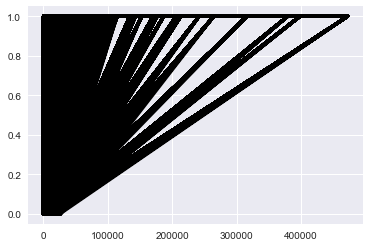

In [62]:
plt.plot(X_test, y_pred, color='black', linewidth=3)
plt.show()

In [65]:
# Compute and print R^2 and RMSE
from sklearn.metrics import mean_squared_error
print("R^2: {}".format(model.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


R^2: 0.656753007812
Root Mean Squared Error: 0.585872846433


## Trying other models

In [66]:
from sklearn.neighbors import KNeighborsClassifier
knn =KNeighborsClassifier(n_neighbors =6) #Instantiate a classifier by specifying the parameter
knn.fit(X_train,y_train)

/Users/Gary/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [67]:
y_pred_knn =knn.predict(X_test)

In [68]:
training_accuracy_knn = knn.score(X_train, y_train)
test_accuracy_knn = knn.score(X_test, y_test)
print("Accuracy on training data: {:0.5f}".format(training_accuracy_knn))
print("Accuracy on test data:     {:0.5f}".format(test_accuracy_knn))

Accuracy on training data: 0.74742
Accuracy on test data:     0.64599
